In [1]:
from google.cloud import vision
from google.cloud.vision import types
import io
from PIL import Image, ImageDraw
from enum import Enum

In [2]:
image_file='Desktop/Wachovia_National.jpg'
image  = Image.open(image_file)

# Calling the API

In [3]:
client = vision.ImageAnnotatorClient()
with io.open(image_file, 'rb') as image_file1:
        content = image_file1.read()
content_image = types.Image(content=content)
response = client.document_text_detection(image=content_image)
document = response.full_text_annotation

# Plotting bounding boxes from the response.

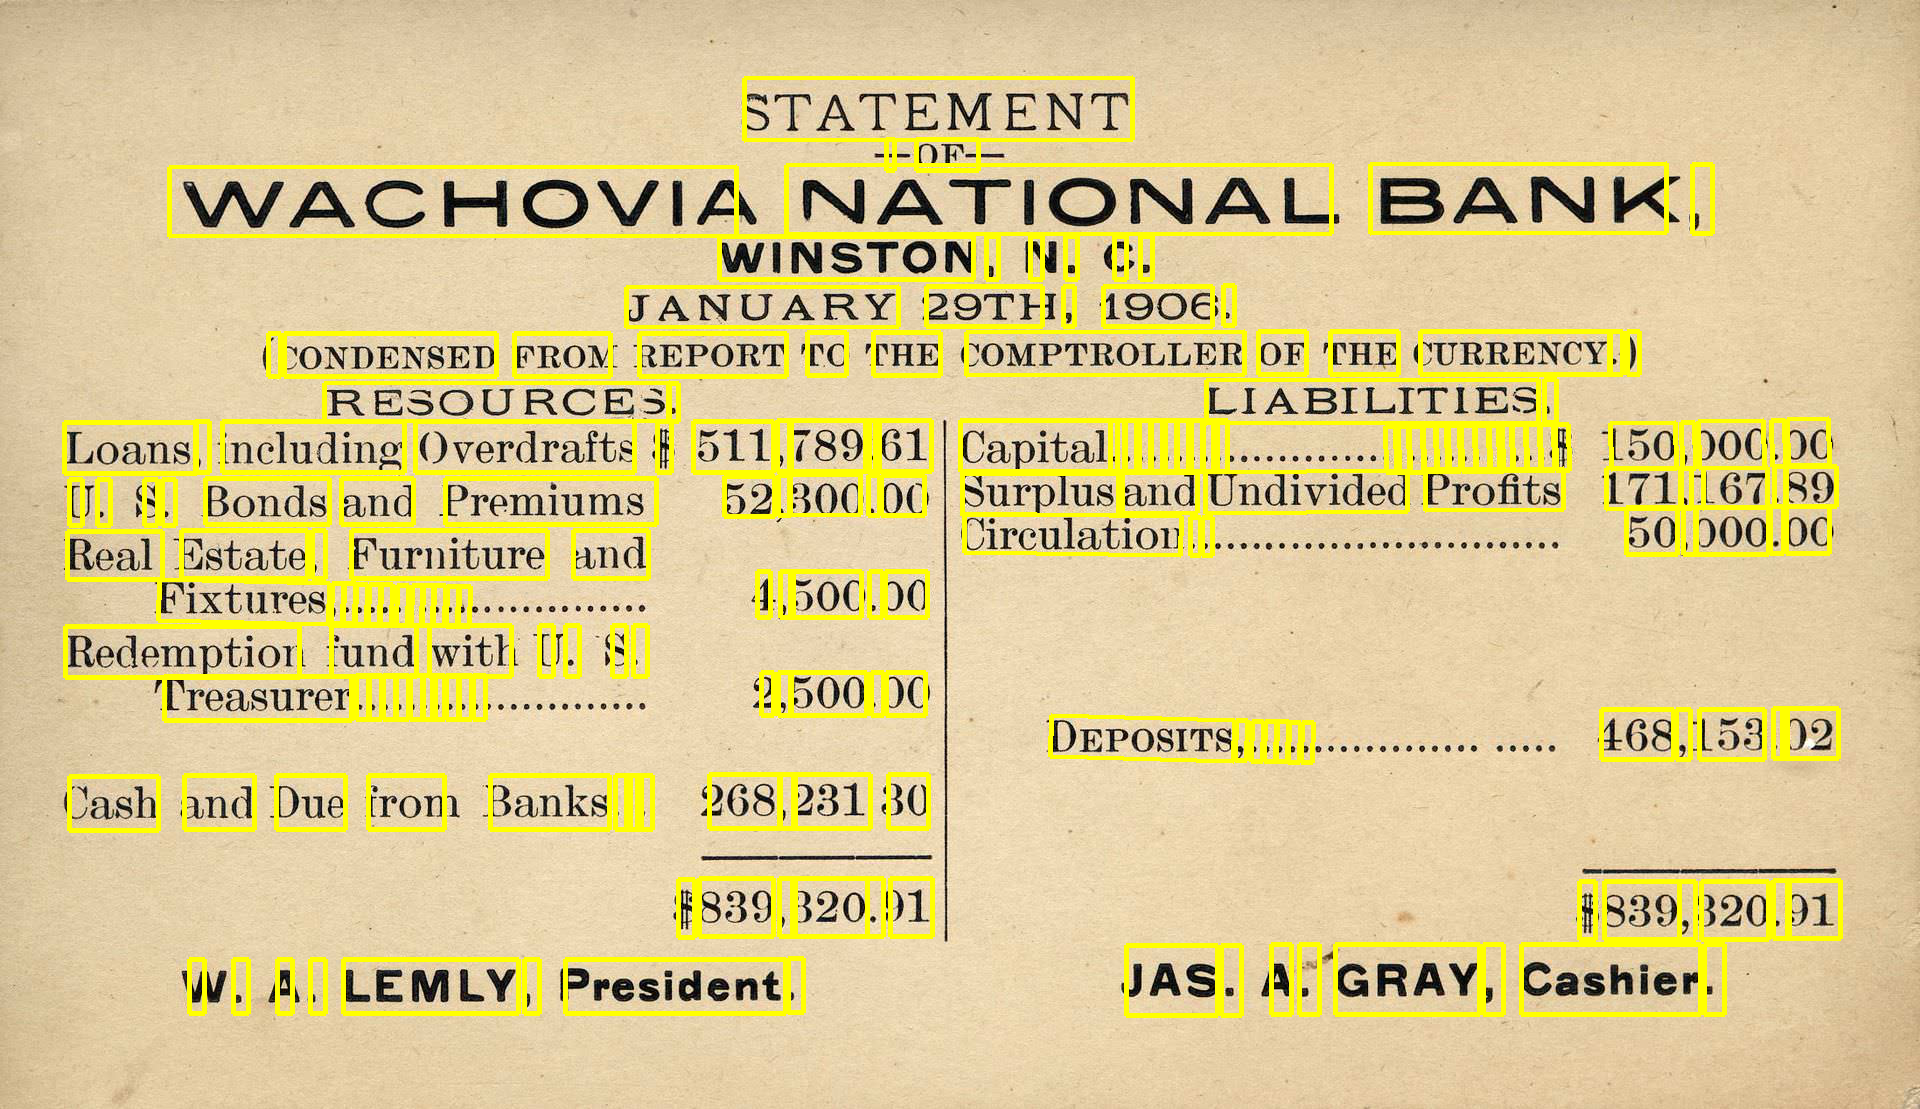

In [4]:
class FeatureType(Enum):
    PAGE = 1
    BLOCK = 2
    PARA = 3
    WORD = 4
    SYMBOL = 5
    
def draw_boxes(image, bounds, color,width=5):
    draw = ImageDraw.Draw(image)
    for bound in bounds:
        draw.line([
            bound.vertices[0].x, bound.vertices[0].y,
            bound.vertices[1].x, bound.vertices[1].y,
            bound.vertices[2].x, bound.vertices[2].y,
            bound.vertices[3].x, bound.vertices[3].y,
            bound.vertices[0].x, bound.vertices[0].y],fill=color, width=width)
    return image

def get_document_bounds(response, feature):
    bounds=[]
    for i,page in enumerate(document.pages):
        for block in page.blocks:
            if feature==FeatureType.BLOCK:
                bounds.append(block.bounding_box)
            for paragraph in block.paragraphs:
                if feature==FeatureType.PARA:
                    bounds.append(paragraph.bounding_box)
                for word in paragraph.words:
                    for symbol in word.symbols:
                        if (feature == FeatureType.SYMBOL):
                            bounds.append(symbol.bounding_box)
                    if (feature == FeatureType.WORD):
                        bounds.append(word.bounding_box)
    return bounds

bounds = get_document_bounds(response, FeatureType.WORD)
draw_boxes(image, bounds, 'yellow')

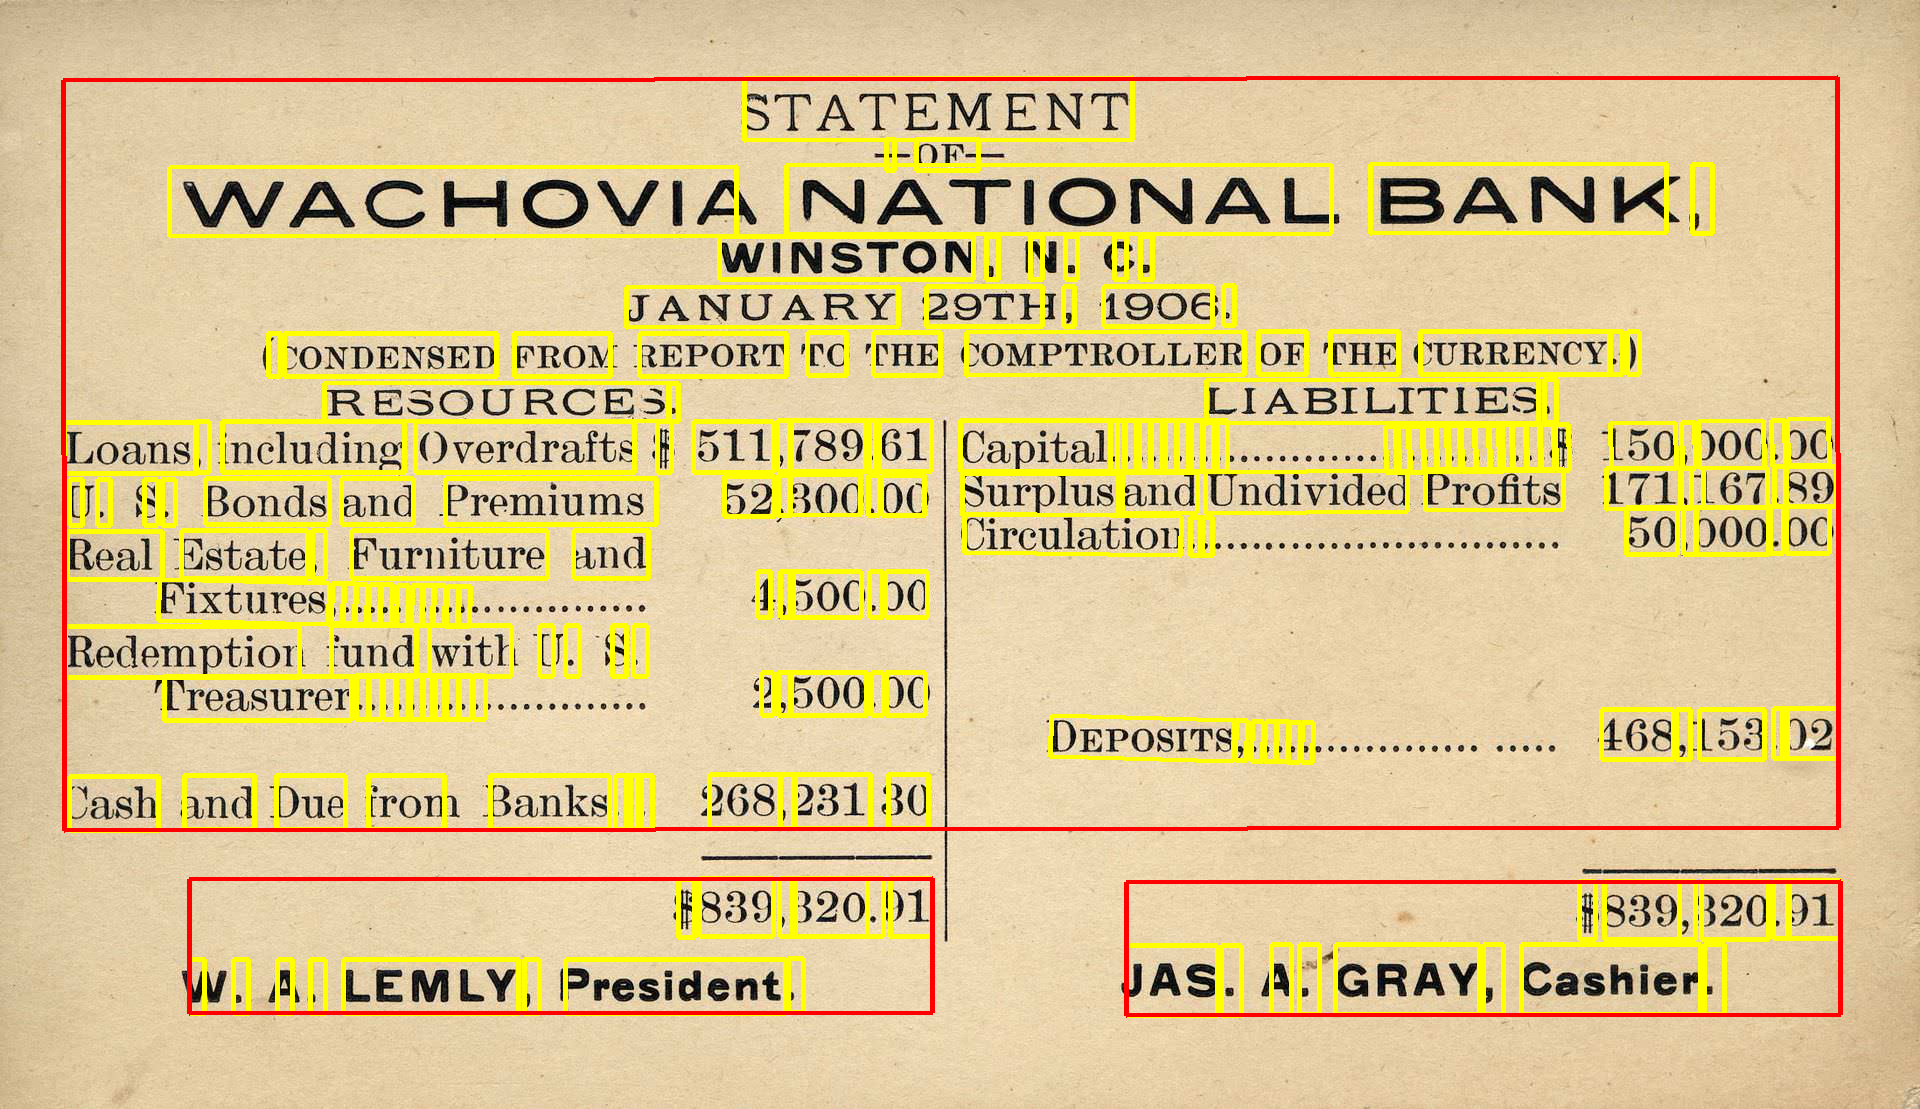

In [5]:
#FOR BLOCKS
bounds = get_document_bounds(response, FeatureType.BLOCK)
draw_boxes(image, bounds, 'red')

# Finding location of a word

In [17]:
def assemble_word(word):
    assembled_word=""
    for symbol in word.symbols:
        assembled_word+=symbol.text
    return assembled_word

def find_word_location(document,word_to_find):
    for page in document.pages:
        for block in page.blocks:
            for paragraph in block.paragraphs:
                for word in paragraph.words:
                    assembled_word=assemble_word(word)
                    if(assembled_word==word_to_find):
                        return word.bounding_box
                    
vision_client = vision.ImageAnnotatorClient()

with io.open(image_file, 'rb') as image_file2:
    content = image_file2.read()

content_image = types.Image(content=content)
response = client.document_text_detection(image=content_image)
document = response.full_text_annotation

find_word_location(document,'NATIONAL')

vertices {
  x: 786
  y: 165
}
vertices {
  x: 1331
  y: 164
}
vertices {
  x: 1331
  y: 233
}
vertices {
  x: 786
  y: 234
}

# Finding word inside

In [15]:
def text_within(document,x1,y1,x2,y2): 
    text=""
    for page in document.pages:
        for block in page.blocks:
            for paragraph in block.paragraphs:
                for word in paragraph.words:
                    for symbol in word.symbols:
                        min_x=min(symbol.bounding_box.vertices[0].x,symbol.bounding_box.vertices[1].x,symbol.bounding_box.vertices[2].x,symbol.bounding_box.vertices[3].x)
                        max_x=max(symbol.bounding_box.vertices[0].x,symbol.bounding_box.vertices[1].x,symbol.bounding_box.vertices[2].x,symbol.bounding_box.vertices[3].x)
                        min_y=min(symbol.bounding_box.vertices[0].y,symbol.bounding_box.vertices[1].y,symbol.bounding_box.vertices[2].y,symbol.bounding_box.vertices[3].y)
                        max_y=max(symbol.bounding_box.vertices[0].y,symbol.bounding_box.vertices[1].y,symbol.bounding_box.vertices[2].y,symbol.bounding_box.vertices[3].y)
                        if(min_x >= x1 and max_x <= x2 and min_y >= y1 and max_y <= y2):
                            text+=symbol.text
                            if(symbol.property.detected_break.type==1 or 
                               symbol.property.detected_break.type==3):
                                text+=' '
                            if(symbol.property.detected_break.type==2):
                                text+='\t'
                            if(symbol.property.detected_break.type==5):
                                text+='\n'
    return text

In [22]:
text_within(document, 786,165,1331,234)

'NATIONA'